In [1]:
import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy
import metpy.calc as mpcalc
from metpy.plots import SkewT, PlotVector
from metpy.units import units 
from IPython.display import HTML, display
import imageio
from tqdm import tqdm
from itertools import product
import wrf
import glob
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
#Create Path For Data Collection and Create A List of File Names
prestorm_data_path = '/storage/group/pmm116/default/pmm116/predictability_study-30sec-output/prestorm16/'
file_paths = glob.glob(prestorm_data_path + "*00*.nc")
filenames = sorted([Path(path).name for path in file_paths if path.endswith(".nc")])

#Step 1: Initialization and Input Parameters

#Data at t = 2hrs
prestorm_data = xr.open_dataset(prestorm_data_path + filenames[0])

#Dataset Domain Size
ni = prestorm_data['ni']
nj = prestorm_data['nj']
nk = prestorm_data['nk']

#Datapoint Locations
x_data = prestorm_data['xh']*units.kilometer
y_data = prestorm_data['yh']*units.kilometer
z_data = prestorm_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = prestorm_data['xf']*units.kilometer
y_grid = prestorm_data['yf']*units.kilometer
z_grid = prestorm_data['zf']*units.kilometer

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values + 12.5).argmin()-2
upper_bound_x = np.abs(x_data.values - 12.5).argmin()
lower_bound_y = np.abs(y_data.values + 12.5).argmin()
upper_bound_y = np.abs(y_data.values - 12.5).argmin()+2
horiz_length = upper_bound_y-lower_bound_y

#Grid Size 
size_x = size_y = upper_bound_x-lower_bound_x
size_z = len(z_data)

#Grid Spacing 
dx = x_data[1].values - x_data[0].values
dy = y_data[1].values - y_data[0].values
dz = np.zeros(len(z_data))
dz[0] = z_data[0].values
dz[1:] = z_data[1:].values-z_data[0:-1].values

#Time Intervals of Data
time = []
for x in np.arange(0,len(filenames),1):
    t = xr.open_dataset(prestorm_data_path + filenames[x])['time']
    time.append(t)    
time = (np.asarray(time)*10**-9).reshape(len(time))
time = time.astype('int')
time = time - time[0] #time elapsed in seconds (useful for interpolation later on)

#Time Intervals of Interpolation (We want every 10 seconds)
int_time = np.arange(int(time[0]), int(time[-1]), 10)
nanal = len(int_time) #Number of Trajectory Points 
dt = int_time[1]-int_time[0]

#Input Parameters 
asc_rate = 5 #3 m/s ascent rate of balloon

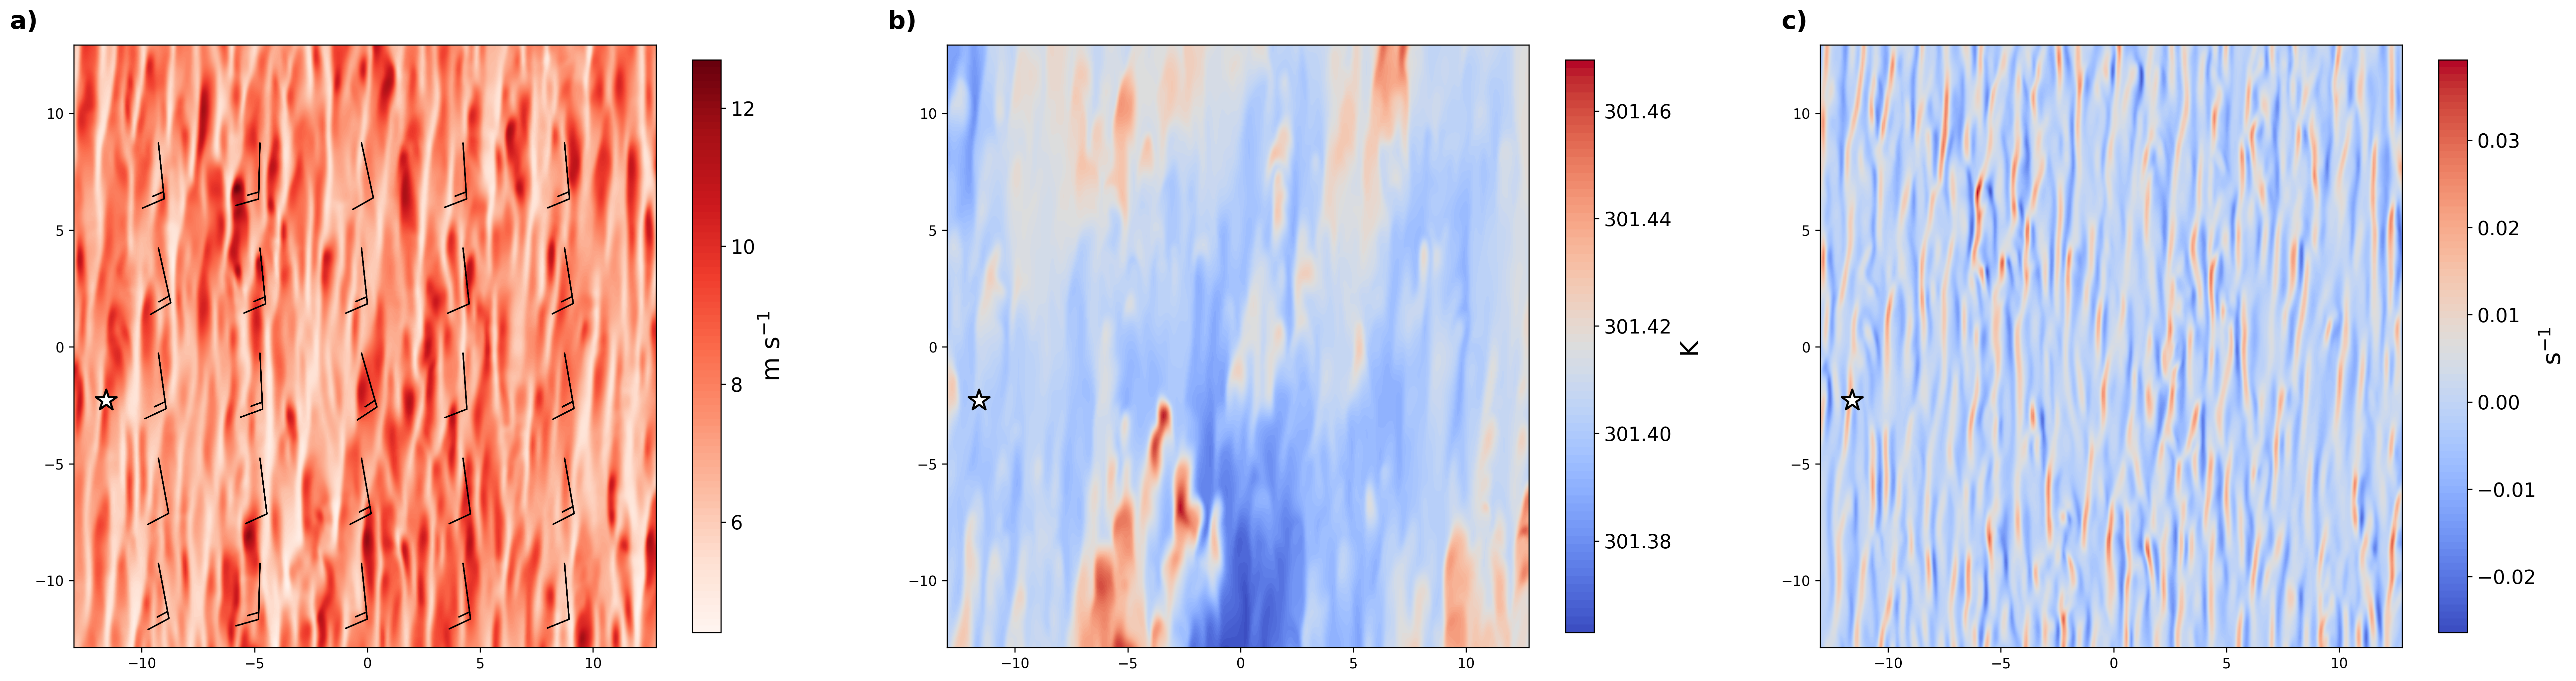

In [3]:
# Create a Lay of the Land Type of Plot to show base state variables at the start of the simulation within the 25 by 25 km box 

# Initialize Figure
fig, axs = plt.subplots(ncols = 3, nrows =1, figsize=(32,8), dpi=300)
#plt.subplots_adjust(wspace=0.05, hspace =.2)

# --------------------------------------------------------------------------------------------------------------------------

# First Plot: Wind Speed with Barbs 

# Step 1: Calculate Wind Speed
model_u = xr.DataArray(prestorm_data['uinterp'].isel(time = 0, nk = 0, nj = slice(lower_bound_y-5, upper_bound_y+5), ni = slice(lower_bound_x-5, upper_bound_x+5)) + 12.2) 
model_v = xr.DataArray(prestorm_data['vinterp'].isel(time = 0, nk = 0, nj = slice(lower_bound_y-5, upper_bound_y+5), ni = slice(lower_bound_x-5, upper_bound_x+5)) + 12.5)
model_speed = mpcalc.wind_speed(model_u*units.meter_per_second, model_v*units.meter_per_second)

# Step 2: Plot Contour and Barbs 

# Contour 
ax1 = axs[0].contourf(x_data[lower_bound_x-5:upper_bound_x+5], y_data[lower_bound_y-5:upper_bound_y+5], model_speed, levels = 100, cmap='Reds')
cbar1 = fig.colorbar(ax1, ax=axs[0], orientation='vertical', shrink = 0.95, ticks = np.arange(4, 17, 2))
cbar1.set_label(label = 'm s$^{-1}$', fontsize = 18)
cbar1.ax.tick_params(labelsize=14)
#axs[0].set_aspect('equal')
# Barbs 
skip = (slice(50, 340, 60), slice(50, 340, 60))
x2d, y2d = np.meshgrid(x_data[lower_bound_x-5:upper_bound_x+5], y_data[lower_bound_x-5:upper_bound_x+5])
axs[0].barbs(x2d[skip], y2d[skip], model_u[skip], model_v[skip], length=9, barb_increments={'half': 2.57222, 'full': 5.14444, 'flag': 12.8611})

# --------------------------------------------------------------------------------------------------------------------------

# Second Plot: Potential Temperature

model_Th = prestorm_data['th'].isel(time = 0, nk = 0, nj = slice(lower_bound_y-5, upper_bound_y+5), ni = slice(lower_bound_x - 5, upper_bound_x +5))
ax2 = axs[1].contourf(x_data[lower_bound_x-5:upper_bound_x+5], y_data[lower_bound_y-5:upper_bound_y+5], model_Th, levels = 100, cmap = 'coolwarm')
cbar2 = fig.colorbar(ax2, ax=axs[1], orientation='vertical', shrink = 0.95, ticks = np.arange(301.3, 301.5, 0.02))
cbar2.set_label(label = 'K', fontsize = 18)
cbar2.ax.tick_params(labelsize=14)
#axs[1].set_aspect('equal')


# --------------------------------------------------------------------------------------------------------------------------

# Third Plot: Vertical Vorticity

model_zvort = prestorm_data['zvort'].isel(time = 0, nk = 0, nj = slice(lower_bound_y-5, upper_bound_y+5), ni = slice(lower_bound_x - 5, upper_bound_x +5))
ax3 = axs[2].contourf(x_data[lower_bound_x-5:upper_bound_x+5], y_data[lower_bound_y-5:upper_bound_y+5], model_zvort, levels = 100, cmap = 'coolwarm')
cbar3 = fig.colorbar(ax3, ax=axs[2], orientation='vertical', shrink = 0.95, ticks = np.arange(-0.06, 0.04, 0.01))
cbar3.set_label(label = 's$^{-1}$', fontsize = 18)
cbar3.ax.tick_params(labelsize=14)
#axs[2].set_aspect('equal')

# --------------------------------------------------------------------------------------------------------------------------

# Add text labels to each top right corner
fig.text(0.105, 0.9, 'a)', fontsize = 18, weight = 'demibold')
fig.text(0.38, 0.9, 'b)', fontsize = 18, weight = 'demibold')
fig.text(0.66, 0.9, 'c)', fontsize = 18, weight = 'demibold')

# --------------------------------------------------------------------------------------------------------------------------

# Plot the Location of the randomly selected sounding for comparison with a star (array([-11.58750057,  -2.28750014]))

axs[0].scatter(-11.59, -2.28, s = 250, c='white', edgecolor='black', linewidth=1.5,marker='*')
axs[1].scatter(-11.59, -2.28, s = 250, c='white', edgecolor='black', linewidth=1.5,marker='*')
axs[2].scatter(-11.59, -2.28, s = 250, c='white', edgecolor='black', linewidth=1.5,marker='*')

#--------------------------------------------------------------------------------------------------------------------------

# Final Step
# plt.tight_layout()
plt.show()

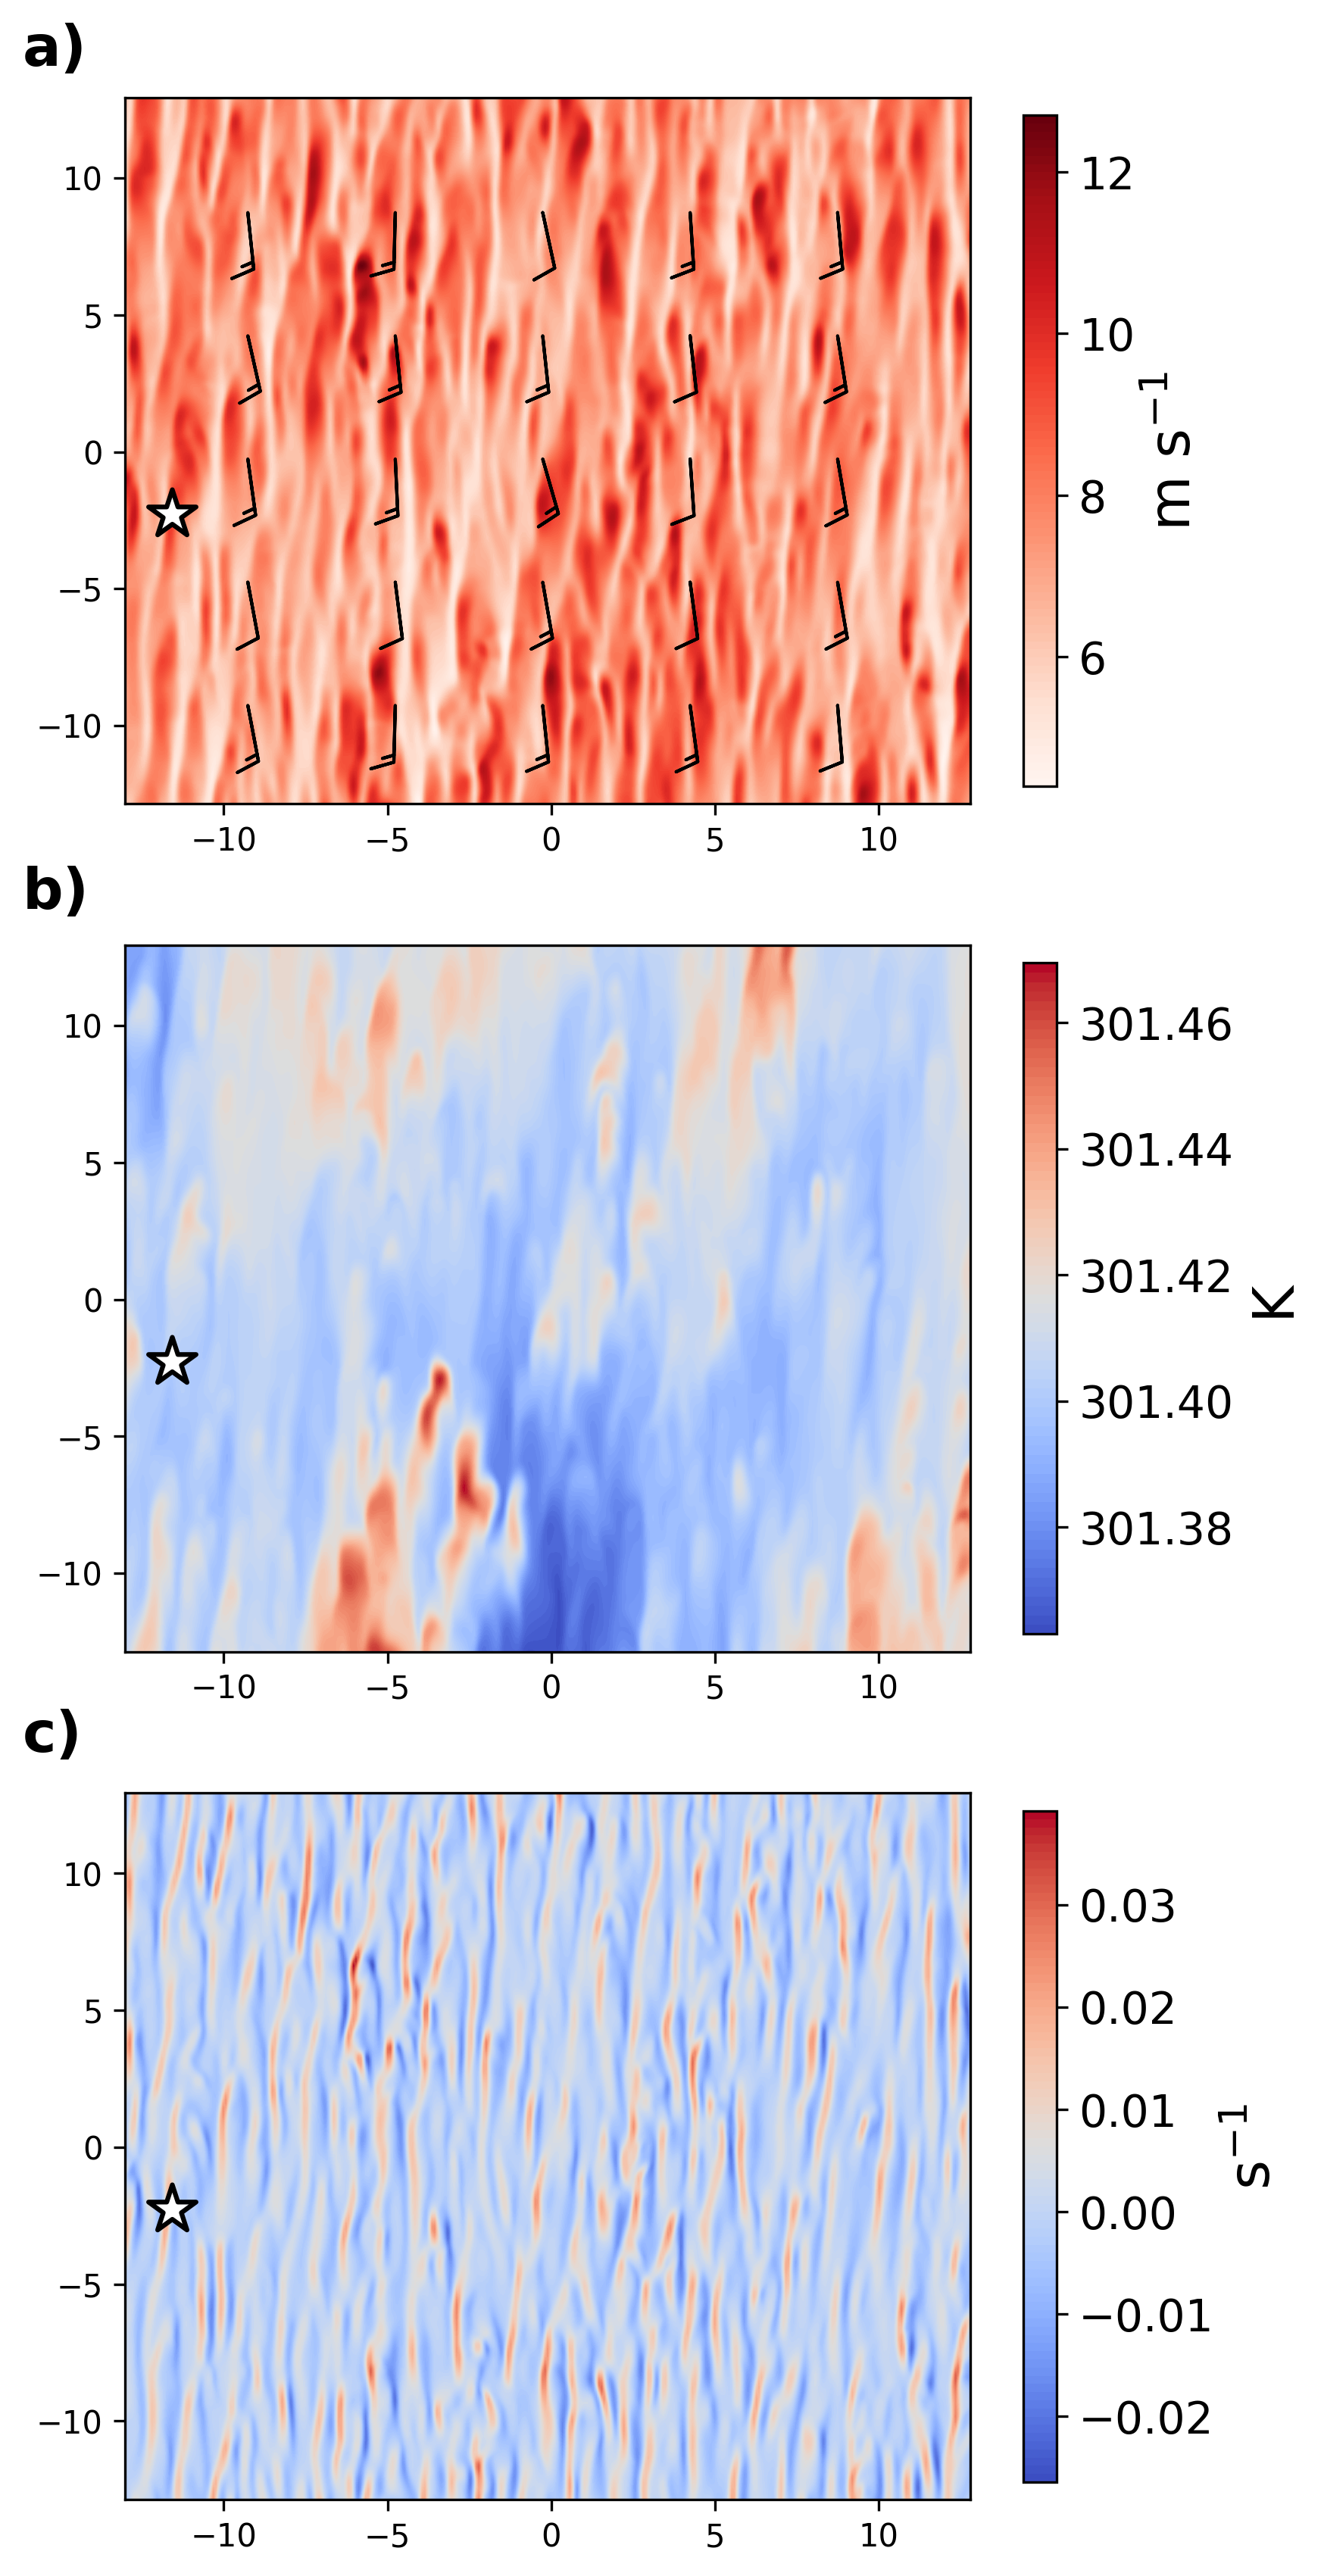

In [4]:
# Create a Lay of the Land Type of Plot to show base state variables at the start of the simulation within the 25 by 25 km box 

# Initialize Figure
fig, axs = plt.subplots(ncols = 1, nrows =3, figsize=(6, 14), dpi=300)
#plt.subplots_adjust(wspace=0.05, hspace =.2)

# --------------------------------------------------------------------------------------------------------------------------

# First Plot: Wind Speed with Barbs 

# Step 1: Calculate Wind Speed
model_u = xr.DataArray(prestorm_data['uinterp'].isel(time = 0, nk = 0, nj = slice(lower_bound_y-5, upper_bound_y+5), ni = slice(lower_bound_x-5, upper_bound_x+5)) + 12.2) 
model_v = xr.DataArray(prestorm_data['vinterp'].isel(time = 0, nk = 0, nj = slice(lower_bound_y-5, upper_bound_y+5), ni = slice(lower_bound_x-5, upper_bound_x+5)) + 12.5)
model_speed = mpcalc.wind_speed(model_u*units.meter_per_second, model_v*units.meter_per_second)

# Step 2: Plot Contour and Barbs 

# Contour 
ax1 = axs[0].contourf(x_data[lower_bound_x-5:upper_bound_x+5], y_data[lower_bound_y-5:upper_bound_y+5], model_speed, levels = 100, cmap='Reds')
cbar1 = fig.colorbar(ax1, ax=axs[0], orientation='vertical', shrink = 0.95, ticks = np.arange(4, 17, 2))
cbar1.set_label(label = 'm s$^{-1}$', fontsize = 18)
cbar1.ax.tick_params(labelsize=14)
#axs[0].set_aspect('equal')
# Barbs 
skip = (slice(50, 340, 60), slice(50, 340, 60))
x2d, y2d = np.meshgrid(x_data[lower_bound_x-5:upper_bound_x+5], y_data[lower_bound_x-5:upper_bound_x+5])
axs[0].barbs(x2d[skip], y2d[skip], model_u[skip], model_v[skip], length=6, barb_increments={'half': 2.57222, 'full': 5.14444, 'flag': 12.8611})

# --------------------------------------------------------------------------------------------------------------------------

# Second Plot: Potential Temperature

model_Th = prestorm_data['th'].isel(time = 0, nk = 0, nj = slice(lower_bound_y-5, upper_bound_y+5), ni = slice(lower_bound_x - 5, upper_bound_x +5))
ax2 = axs[1].contourf(x_data[lower_bound_x-5:upper_bound_x+5], y_data[lower_bound_y-5:upper_bound_y+5], model_Th, levels = 100, cmap = 'coolwarm')
cbar2 = fig.colorbar(ax2, ax=axs[1], orientation='vertical', shrink = 0.95, ticks = np.arange(301.3, 301.5, 0.02))
cbar2.set_label(label = 'K', fontsize = 18)
cbar2.ax.tick_params(labelsize=14)
#axs[1].set_aspect('equal')


# --------------------------------------------------------------------------------------------------------------------------

# Third Plot: Vertical Vorticity

model_zvort = prestorm_data['zvort'].isel(time = 0, nk = 0, nj = slice(lower_bound_y-5, upper_bound_y+5), ni = slice(lower_bound_x - 5, upper_bound_x +5))
ax3 = axs[2].contourf(x_data[lower_bound_x-5:upper_bound_x+5], y_data[lower_bound_y-5:upper_bound_y+5], model_zvort, levels = 100, cmap = 'coolwarm')
cbar3 = fig.colorbar(ax3, ax=axs[2], orientation='vertical', shrink = 0.95, ticks = np.arange(-0.06, 0.04, 0.01))
cbar3.set_label(label = 's$^{-1}$', fontsize = 18)
cbar3.ax.tick_params(labelsize=14)
#axs[2].set_aspect('equal')

# --------------------------------------------------------------------------------------------------------------------------

# Add text labels to each top right corner
fig.text(0.05, 0.89, 'a)', fontsize = 18, weight = 'demibold')
fig.text(0.05, 0.625, 'b)', fontsize = 18, weight = 'demibold')
fig.text(0.05, 0.36, 'c)', fontsize = 18, weight = 'demibold')

# --------------------------------------------------------------------------------------------------------------------------

# Plot the Location of the randomly selected sounding for comparison with a star (array([-11.58750057,  -2.28750014]))

axs[0].scatter(-11.59, -2.28, s = 250, c='white', edgecolor='black', linewidth=1.5,marker='*')
axs[1].scatter(-11.59, -2.28, s = 250, c='white', edgecolor='black', linewidth=1.5,marker='*')
axs[2].scatter(-11.59, -2.28, s = 250, c='white', edgecolor='black', linewidth=1.5,marker='*')

#--------------------------------------------------------------------------------------------------------------------------

# Final Step
# plt.tight_layout()
plt.show()

In [4]:
#Load The pseudo_data

path = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/Data/'
pseudo_data = np.load(path+'pseudodata_2_cm1grid.npz')
points_data = np.load(path+'instantaneous_data.npz')


#Data Interpolated to Model Grid
P = pseudo_data['P']
T = pseudo_data['T']
Th = pseudo_data['Th']
Td = pseudo_data['Td']
qv = pseudo_data['qv']
u = pseudo_data['u']
v = pseudo_data['v']
w = pseudo_data['w']
zvort = pseudo_data['zvort']
parc_T = pseudo_data['parc_T']
CAPE = pseudo_data['CAPE']
CIN = pseudo_data['CIN']
SRH1km = pseudo_data['SRH1km']
SRH3km = pseudo_data['SRH3km']

#Original Trajectory Points
# points = pseudo_data['interp_points']

#Ground Relative Winds
offset_u = 12.2 
offset_v = 12.5 
gr_u = u[0] + offset_u
gr_v = v[0] + offset_v
gr_wind = np.sqrt((gr_u**2)+(gr_v**2)) 

inst_data = np.load(path+'instantaneous_data.npz')
points_data = np.load(path+'interpolation_2_rawtrajectories.npz')

inst_P = inst_data['P']
inst_T = inst_data['T']
inst_Td = inst_data['Td']
inst_Th = inst_data['Th']
inst_qv = inst_data['qv']
inst_u = inst_data['u']
inst_v = inst_data['v']
inst_w = inst_data['w']
inst_zvort = inst_data['zvort']
inst_parc_T = inst_data['parc_T']
inst_CAPE = inst_data['CAPE']
inst_CIN = inst_data['CIN']
inst_SRH1km = inst_data['SRH1km']
inst_SRH3km = inst_data['SRH3km']

#Original Trajectory Points
points = points_data['interp_points']

#Ground Relative Winds
offset_u = 12.2
offset_v = 12.5 
gr_u = inst_u[0]+offset_u
gr_v = inst_v[0]+offset_v
inst_gr_wind = np.sqrt((gr_u**2)+(gr_v**2))

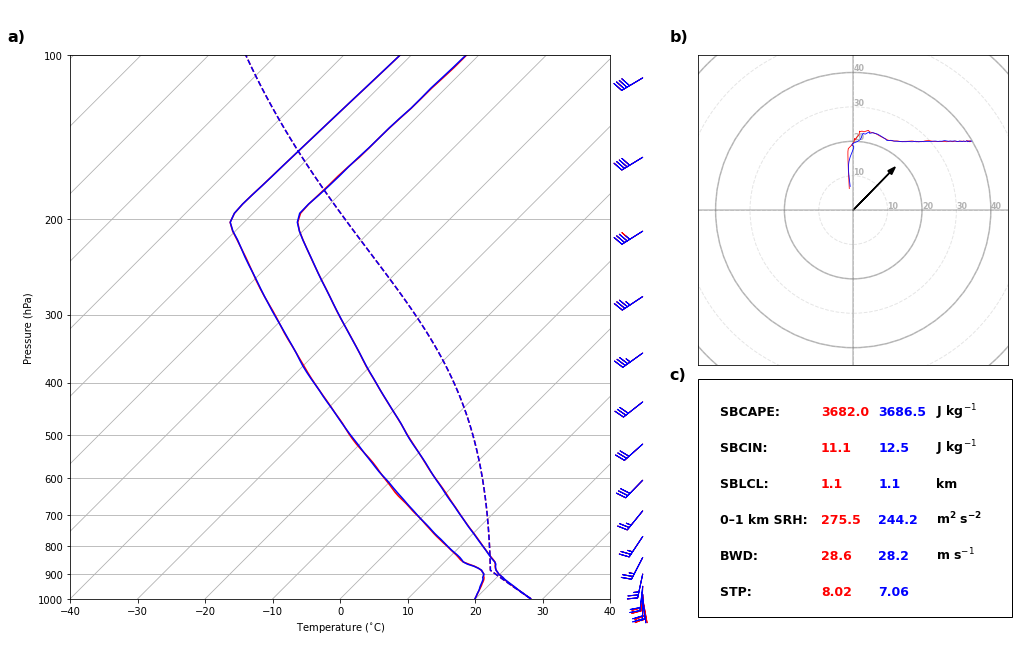

In [18]:
# Random Index
k = np.random.randint(0, P.shape[1])

# Initialize SkewT
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig, rotation=45)

# Image Filename
image_filename = "figure_%03d.png" % (x)

# Initialize Hodograph   
ax = fig.add_axes((1.01, 0.45, 0.43, 0.43))
h = metpy.plots.Hodograph(ax, component_range=45.)

# Add alternating grid increments
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)


# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)

# Cosmetic Touches
skew.ax.set_xlabel('Temperature ($^{\circ}$C)')
skew.ax.set_ylabel('Pressure (hPa)')

#Relative Storm Motion 
offset_u = 12.2*units.meter_per_second
offset_v = 12.5*units.meter_per_second

# Plot Bunkers Storm Motion
h.ax.arrow(0, 0, offset_u.magnitude, offset_v.magnitude, linewidth=1.5, color='black', length_includes_head=True, head_width=1.5)

# ---------------------------------------------------------------------------------------------------------------

# Plot PseudoSounding
length = len(P[:,k][::8])
skew.plot(P[:,k]*units.Pa, T[:,k]*units.degK, color='r')
skew.plot(P[:,k]*units.Pa, Td[:,k]*units.degK, color = 'r')
skew.plot(P[:,k]*units.Pa, parc_T[:,k]*units.degK, color = 'r', linestyle = '--')
skew.plot_barbs(P[:,k][::8]*units.Pa, u[:,k][::8]*units.meter_per_second+offset_u, 
                v[:,k][::8]*units.meter_per_second+offset_v, color = 'r', xloc=1.06, y_clip_radius = 0.09)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# Plot Pseudo Hodograph
h.plot(u[:,k]*units.meter_per_second+offset_u, v[:,k]*units.meter_per_second+offset_v, color='r', linewidth = 0.8)

# Plot Instantaneous Sounding/Hodograph
length = len(inst_P[:,k][::8])
skew.plot(inst_P[:,k]*units.Pa, inst_T[:,k]*units.degK, color='b')
skew.plot(inst_P[:,k]*units.Pa, inst_Td[:,k]*units.degK, color = 'b')
skew.plot(inst_P[:,k]*units.Pa, inst_parc_T[:,k]*units.degK, color = 'b', linestyle = '--')
skew.plot_barbs(inst_P[:,k][::8]*units.Pa, inst_u[:,k][::8]*units.meter_per_second+offset_u, 
                inst_v[:,k][::8]*units.meter_per_second+offset_v, color = 'b', xloc=1.06, y_clip_radius = 0.09)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# Plot Instantaneous Hodograph
h.plot(inst_u[:,k]*units.meter_per_second+offset_u, inst_v[:,k]*units.meter_per_second+offset_v, color='b', linewidth = 0.8)

# ---------------------------------------------------------------------------------------------------------------------------------

# Compute Forecasting Parameters

# Pseudo Profile Parameters 
# CAPE/CIN (wrf)
Height = z_data*1000 #"Geopotential Height"
Terrain = 0 #Terrain (Assuming Flat Surface)
P_sfc = P[:,k][0]/100 # Surface Pressure
# WRF CAPE Computation
results = wrf.cape_3d(P[:,k]/100, T[:,k], qv[:,k], Height, Terrain, P_sfc, ter_follow = True, meta = True)
SBCAPE = results[0][0].values
SBCIN = results[1][0].values
SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                        u[:,k]*units.meter_per_second+offset_u, v[:,k]*units.meter_per_second+offset_v, bottom = 7.5*units('m'), 
                                        depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
# LCL
p_LCL = mpcalc.lcl(P[:,k][0]*units.Pa, T[:,k][0]*units.degK, Td[:,k][0]*units.degK)[0]
SBLCL = mpcalc.pressure_to_height_std(p_LCL)
# Height indices for ~ 0, 6 km and BWD
z_6km = (np.abs(z_data.values -6)).argmin()
z_0km = 0
u_sfc = u[:,k][z_0km]
v_sfc = v[:,k][z_0km]
u_6km = u[:,k][z_6km]
v_6km = v[:,k][z_6km]
BWD_u = u_6km - u_sfc
BWD_v = v_6km - v_sfc
BWD = ((BWD_u**2 + BWD_v**2)**(1/2))
# STP
STP = (SBCAPE/1500)*((2000-1000*SBLCL.magnitude)/1000)*(SRH1km.magnitude/150)*((200+SBCIN)/150)*(BWD/20)


# Instantaneous Profile Parameters
Height = z_data*1000 #"Geopotential Height"
Terrain = 0 #Terrain (Assuming Flat Surface)
inst_P_sfc = inst_P[:,k][0]/100 # Surface Pressure
# WRF CAPE Computation
results = wrf.cape_3d(inst_P[:,k]/100, inst_T[:,k], inst_qv[:,k], Height, Terrain, inst_P_sfc, ter_follow = True, meta = True)
inst_SBCAPE = results[0][0].values
inst_SBCIN = results[1][0].values
# Print Comparison
#print(f'Metpy: {CIN}, WRF: {SBCIN}')
inst_SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                        inst_u[:,k]*units.meter_per_second+offset_u, inst_v[:,k]*units.meter_per_second+offset_v, bottom = 7.5*units('m'), 
                                        depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
# LCL
inst_p_LCL = mpcalc.lcl(inst_P[:,k][0]*units.Pa, inst_T[:,k][0]*units.degK, inst_Td[:,k][0]*units.degK)[0]
inst_SBLCL = mpcalc.pressure_to_height_std(inst_p_LCL)
# Height indices for ~ 0, 6 km and BWD
z_6km = (np.abs(z_data.values -6)).argmin()
z_0km = 0
u_sfc = inst_u[:,k][z_0km]
v_sfc = inst_v[:,k][z_0km]
u_6km = inst_u[:,k][z_6km]
v_6km = inst_v[:,k][z_6km]
BWD_u = u_6km - u_sfc
BWD_v = v_6km - v_sfc
inst_BWD = ((BWD_u**2 + BWD_v**2)**(1/2))
# STP
inst_STP = (inst_SBCAPE/1500)*((2000-1000*inst_SBLCL.magnitude)/1000)*(inst_SRH1km.m/150)*((200+inst_SBCIN)/150)*(inst_BWD/20)

# --------------------------------------------------------------------------------------------------------------------------

# List Forecasting Parameters in Text Box 

fig.patches.extend([plt.Rectangle((1.01, 0.1), 0.435, 0.33,
                                  edgecolor='black', facecolor='white',
                                  linewidth=1, alpha=1, transform=fig.transFigure,
                                  figure=fig)])
# Add each parameter title to the bottom right text box
fig.text(1.04, 0.38, 'SBCAPE: ', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.04, 0.33, 'SBCIN: ', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.04, 0.28, 'SBLCL: ', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.04, 0.23, '0–1 km SRH: ', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.04, 0.18, 'BWD: ', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.04, 0.13, 'STP: ', weight='bold', fontsize=12.5,
            color='k')

# Plot PseudoValues
fig.text(1.18, 0.38, f'{round(float(SBCAPE), 1)}', weight='bold', fontsize=12.5,
            color='red')
fig.text(1.18, 0.33, f'{round(float(SBCIN), 1)}', weight='bold', fontsize=12.5,
            color='red')
fig.text(1.18, 0.28, f'{round(float(SBLCL.m), 1)}', weight='bold', fontsize=12.5,
            color='red')
fig.text(1.18, 0.23, f'{round(SRH1km.m,1)}', fontsize=12.5, weight='bold',
            color='red')
fig.text(1.18, 0.18, f'{round(float(BWD), 1)}', weight='bold', fontsize=12.5,
            color='red')
fig.text(1.18, 0.13, f'{round(STP,2)}', weight='bold', fontsize=12.5,
            color='red')


# Plot Instantaneous Values 
fig.text(1.26, 0.38, f'{round(float(inst_SBCAPE), 1)}', weight='bold', fontsize=12.5,
            color='blue')
fig.text(1.26, 0.33, f'{round(float(inst_SBCIN), 1)}', weight='bold', fontsize=12.5,
            color='blue')
fig.text(1.26, 0.28, f'{round(float(inst_SBLCL.m), 1)}', weight='bold', fontsize=12.5,
            color='blue')
fig.text(1.26, 0.23, f'{round(inst_SRH1km.m,1)}', fontsize=12.5, weight='bold',
            color='blue')
fig.text(1.26, 0.18, f'{round(float(inst_BWD), 1)}', weight='bold', fontsize=12.5,
            color='blue')
fig.text(1.26, 0.13, f'{round(inst_STP,2)}', weight='bold', fontsize=12.5,
            color='blue')

# Add Units to each parameters
fig.text(1.34, 0.38, 'J kg$^{-1}$', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.34, 0.33, 'J kg$^{-1}$', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.34, 0.28, 'km', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.34, 0.23, '$\mathbf{{ m^2 \ s^{{-2}}}}$', weight='bold', fontsize=12.5,
            color='k')
fig.text(1.34, 0.18, 'm s$^{-1}$', weight='bold', fontsize=12.5,
            color='k')

# Add subplot labels to skewT and hodograph 
fig.text(0.05, 0.9, 'a)', fontsize = 16, weight = 'bold')
fig.text(0.97, 0.9, 'b)', fontsize = 16, weight = 'bold')
fig.text(0.97, 0.43, 'c)', fontsize = 16, weight = 'bold')


#Save the figure
fig.savefig(path + image_filename, dpi = 200, bbox_inches='tight')

In [19]:
#Try to Plot Multiple (Tweak This To Pick 100 Random Soundings)

path = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/Figure Builder/'
gifname = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/GIFs/100randpseudosoundings_MS.gif'


# This Loop Randomly Selects a point amongst the 112225, and plots the pseudo vs. instantaneous sounding


for x in tqdm(range(100)):
    # Random Index
    k = np.random.randint(0, P.shape[1])

    # Initialize SkewT
    fig = plt.figure(figsize=(10, 10))
    skew = SkewT(fig, rotation=45)
    
    # Image Filename
    image_filename = "figure_%03d.png" % (x)

    # Initialize Hodograph   
    ax = fig.add_axes((1.01, 0.45, 0.43, 0.43))
    h = metpy.plots.Hodograph(ax, component_range=45.)

    # Add alternating grid increments
    h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
    h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)


    # The next few steps makes for a clean hodograph inset, removing the
    # tick marks, tick labels, and axis labels
    h.ax.set_box_aspect(1)
    h.ax.set_yticklabels([])
    h.ax.set_xticklabels([])
    h.ax.set_xticks([])
    h.ax.set_yticks([])
    h.ax.set_xlabel(' ')
    h.ax.set_ylabel(' ')

    # Here we can add a simple Python for loop that adds tick marks
    # to the inside of the hodograph plot to increase readability!
    plt.xticks(np.arange(0, 0, 1))
    plt.yticks(np.arange(0, 0, 1))
    for i in range(10, 120, 10):
        h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                      clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)
    for i in range(10, 120, 10):
        h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                      clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)

    # Cosmetic Touches
    skew.ax.set_xlabel('Temperature ($^{\circ}$C)')
    skew.ax.set_ylabel('Pressure (hPa)')

    #Relative Storm Motion 
    offset_u = 12.2*units.meter_per_second
    offset_v = 12.5*units.meter_per_second

    # Plot Bunkers Storm Motion
    h.ax.arrow(0, 0, offset_u.magnitude, offset_v.magnitude, linewidth=1.5, color='black', length_includes_head=True, head_width=1.5)

    # ---------------------------------------------------------------------------------------------------------------

    # Plot PseudoSounding
    length = len(P[:,k][::8])
    skew.plot(P[:,k]*units.Pa, T[:,k]*units.degK, color='r')
    skew.plot(P[:,k]*units.Pa, Td[:,k]*units.degK, color = 'r')
    skew.plot(P[:,k]*units.Pa, parc_T[:,k]*units.degK, color = 'r', linestyle = '--')
    skew.plot_barbs(P[:,k][::8]*units.Pa, u[:,k][::8]*units.meter_per_second+offset_u, 
                    v[:,k][::8]*units.meter_per_second+offset_v, color = 'r', xloc=1.06, y_clip_radius = 0.09)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 40)

    # Plot Pseudo Hodograph
    h.plot(u[:,k]*units.meter_per_second+offset_u, v[:,k]*units.meter_per_second+offset_v, color='r', linewidth = 0.8)

    # Plot Instantaneous Sounding/Hodograph
    length = len(inst_P[:,k][::8])
    skew.plot(inst_P[:,k]*units.Pa, inst_T[:,k]*units.degK, color='b')
    skew.plot(inst_P[:,k]*units.Pa, inst_Td[:,k]*units.degK, color = 'b')
    skew.plot(inst_P[:,k]*units.Pa, inst_parc_T[:,k]*units.degK, color = 'b', linestyle = '--')
    skew.plot_barbs(inst_P[:,k][::8]*units.Pa, inst_u[:,k][::8]*units.meter_per_second+offset_u, 
                    inst_v[:,k][::8]*units.meter_per_second+offset_v, color = 'b', xloc=1.06, y_clip_radius = 0.09)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 40)

    # Plot Instantaneous Hodograph
    h.plot(inst_u[:,k]*units.meter_per_second+offset_u, inst_v[:,k]*units.meter_per_second+offset_v, color='b', linewidth = 0.8)

    # ---------------------------------------------------------------------------------------------------------------------------------

    # Compute Forecasting Parameters

    # Pseudo Profile Parameters 
    # CAPE/CIN (wrf)
    Height = z_data*1000 #"Geopotential Height"
    Terrain = 0 #Terrain (Assuming Flat Surface)
    P_sfc = P[:,k][0]/100 # Surface Pressure
    # WRF CAPE Computation
    results = wrf.cape_3d(P[:,k]/100, T[:,k], qv[:,k], Height, Terrain, P_sfc, ter_follow = True, meta = True)
    SBCAPE = results[0][0].values
    SBCIN = results[1][0].values
    SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                            u[:,k]*units.meter_per_second+offset_u, v[:,k]*units.meter_per_second+offset_v, bottom = 7.5*units('m'), 
                                            depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
    # LCL
    p_LCL = mpcalc.lcl(P[:,k][0]*units.Pa, T[:,k][0]*units.degK, Td[:,k][0]*units.degK)[0]
    SBLCL = mpcalc.pressure_to_height_std(p_LCL)
    # Height indices for ~ 0, 6 km and BWD
    z_6km = (np.abs(z_data.values -6)).argmin()
    z_0km = 0
    u_sfc = u[:,k][z_0km]
    v_sfc = v[:,k][z_0km]
    u_6km = u[:,k][z_6km]
    v_6km = v[:,k][z_6km]
    BWD_u = u_6km - u_sfc
    BWD_v = v_6km - v_sfc
    BWD = ((BWD_u**2 + BWD_v**2)**(1/2))
    # STP
    STP = (SBCAPE/1500)*((2000-1000*SBLCL.magnitude)/1000)*(SRH1km.magnitude/150)*((200+SBCIN)/150)*(BWD/20)


    # Instantaneous Profile Parameters
    Height = z_data*1000 #"Geopotential Height"
    Terrain = 0 #Terrain (Assuming Flat Surface)
    inst_P_sfc = inst_P[:,k][0]/100 # Surface Pressure
    # WRF CAPE Computation
    results = wrf.cape_3d(inst_P[:,k]/100, inst_T[:,k], inst_qv[:,k], Height, Terrain, inst_P_sfc, ter_follow = True, meta = True)
    inst_SBCAPE = results[0][0].values
    inst_SBCIN = results[1][0].values
    # Print Comparison
    #print(f'Metpy: {CIN}, WRF: {SBCIN}')
    inst_SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                            inst_u[:,k]*units.meter_per_second+offset_u, inst_v[:,k]*units.meter_per_second+offset_v, bottom = 7.5*units('m'), 
                                            depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
    # LCL
    inst_p_LCL = mpcalc.lcl(inst_P[:,k][0]*units.Pa, inst_T[:,k][0]*units.degK, inst_Td[:,k][0]*units.degK)[0]
    inst_SBLCL = mpcalc.pressure_to_height_std(inst_p_LCL)
    # Height indices for ~ 0, 6 km and BWD
    z_6km = (np.abs(z_data.values -6)).argmin()
    z_0km = 0
    u_sfc = inst_u[:,k][z_0km]
    v_sfc = inst_v[:,k][z_0km]
    u_6km = inst_u[:,k][z_6km]
    v_6km = inst_v[:,k][z_6km]
    BWD_u = u_6km - u_sfc
    BWD_v = v_6km - v_sfc
    inst_BWD = ((BWD_u**2 + BWD_v**2)**(1/2))
    # STP
    inst_STP = (inst_SBCAPE/1500)*((2000-1000*inst_SBLCL.magnitude)/1000)*(inst_SRH1km.m/150)*((200+inst_SBCIN)/150)*(inst_BWD/20)

    # --------------------------------------------------------------------------------------------------------------------------

    # List Forecasting Parameters in Text Box 

    fig.patches.extend([plt.Rectangle((1.01, 0.1), 0.435, 0.33,
                                      edgecolor='black', facecolor='white',
                                      linewidth=1, alpha=1, transform=fig.transFigure,
                                      figure=fig)])
    # Add each parameter title to the bottom right text box
    fig.text(1.04, 0.38, 'SBCAPE: ', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.04, 0.33, 'SBCIN: ', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.04, 0.28, 'SBLCL: ', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.04, 0.23, '0–1 km SRH: ', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.04, 0.18, 'BWD: ', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.04, 0.13, 'STP: ', weight='bold', fontsize=12.5,
                color='k')

    # Plot PseudoValues
    fig.text(1.18, 0.38, f'{round(float(SBCAPE), 1)}', weight='bold', fontsize=12.5,
                color='red')
    fig.text(1.18, 0.33, f'{round(float(SBCIN), 1)}', weight='bold', fontsize=12.5,
                color='red')
    fig.text(1.18, 0.28, f'{round(float(SBLCL.m), 1)}', weight='bold', fontsize=12.5,
                color='red')
    fig.text(1.18, 0.23, f'{round(SRH1km.m,1)}', fontsize=12.5, weight='bold',
                color='red')
    fig.text(1.18, 0.18, f'{round(float(BWD), 1)}', weight='bold', fontsize=12.5,
                color='red')
    fig.text(1.18, 0.13, f'{round(STP,2)}', weight='bold', fontsize=12.5,
                color='red')


    # Plot Instantaneous Values 
    fig.text(1.26, 0.38, f'{round(float(inst_SBCAPE), 1)}', weight='bold', fontsize=12.5,
                color='blue')
    fig.text(1.26, 0.33, f'{round(float(inst_SBCIN), 1)}', weight='bold', fontsize=12.5,
                color='blue')
    fig.text(1.26, 0.28, f'{round(float(inst_SBLCL.m), 1)}', weight='bold', fontsize=12.5,
                color='blue')
    fig.text(1.26, 0.23, f'{round(inst_SRH1km.m,1)}', fontsize=12.5, weight='bold',
                color='blue')
    fig.text(1.26, 0.18, f'{round(float(inst_BWD), 1)}', weight='bold', fontsize=12.5,
                color='blue')
    fig.text(1.26, 0.13, f'{round(inst_STP,2)}', weight='bold', fontsize=12.5,
                color='blue')

    # Add Units to each parameters
    fig.text(1.34, 0.38, 'J kg$^{-1}$', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.34, 0.33, 'J kg$^{-1}$', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.34, 0.28, 'km', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.34, 0.23, '$\mathbf{{ m^2 \ s^{{-2}}}}$', weight='bold', fontsize=12.5,
                color='k')
    fig.text(1.34, 0.18, 'm s$^{-1}$', weight='bold', fontsize=12.5,
                color='k')

    # Add subplot labels to skewT and hodograph 
    fig.text(0.05, 0.9, 'a)', fontsize = 16, weight = 'bold')
    fig.text(0.97, 0.9, 'b)', fontsize = 16, weight = 'bold')
    fig.text(0.97, 0.43, 'c)', fontsize = 16, weight = 'bold')
    
    #Save the figure
    fig.savefig(path + image_filename, dpi = 200, bbox_inches='tight')
    
    #clear the figure
    plt.close(fig)

#Creating the GIF
    
    
#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.25
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
#imagefiles.remove('.ipynb_checkpoints')


image_filenames = []

for image_filename in imagefiles[:x]:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames[:x]:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

      




100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


In [ ]:
#Try to Plot Multiple (Tweak This To Pick 100 Random Soundings)

path = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/Figure Builder/'
gifname = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/GIFs/100randpseudosoundings.gif'


for x in tqdm(range(100)):
    
    k = np.random.randint(0,335**2)
    image_filename = "figure_%03d.png" % (x)
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot.
    fig = plt.figure(figsize=(15,10))
    skew = SkewT(fig, rotation=45)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 60)
    skew.plot(P[:,k]*units.Pa, T[:,k]*units.kelvin, 'r')
    skew.plot(P[:,k]*units.Pa, Td[:,k]*units.kelvin, 'r')
    skew.plot_barbs(P[:,k]*units.Pa, u[:,k]*units('m/s'), v[:,k]*units('m/s'))

    # Set some better labels than the default
    skew.ax.set_title(f'100 Random PseudoSoundings (ID: {k})')
    skew.ax.set_xlabel(f'Temperature ({(T[:,k]*units.kelvin).units:~P})')
    skew.ax.set_ylabel(f'Pressure ({(P[:,k]*units.Pa).units:~P})')

    # Calculate full parcel profile and add to plot as black line
    #prof = mpcalc.parc_T(p_avg, T_avg[0], Td_avg[0]).to('degC')
    skew.plot(P[:,k]*units.Pa, parc_T[:,k]*units.kelvin, 'r--', linewidth=2)

    # Add the relevant special lines
    #skew.plot_dry_adiabats()
    #skew.plot_moist_adiabats()
    #skew.plot_mixing_lines()

    #Relative Storm Motion 
    offset_u = 12.2*units.meter_per_second
    offset_v = 12.5*units.meter_per_second
    #Add Hodograph
    ax_hodograph = fig.add_axes([.84, 0.7, 0.18, 0.18])
    h = metpy.plots.Hodograph(ax_hodograph, component_range=40.)
    h.add_grid(increment=5)
    h.plot(u[:, k] * units('m/s')+offset_u, v[:, k] * units('m/s')+offset_v, color='tab:red')
    
    #Save the figure
    fig.savefig(path + image_filename)
    
    #clear the figure
    plt.close()

#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.25
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
#imagefiles.remove('.ipynb_checkpoints')


image_filenames = []

for image_filename in imagefiles[:x]:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames[:x]:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

In [ ]:
#Create A GIF That Randomly Selects 100 Pseudo & Instantanous 

path = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/Figure Builder/'
gifname = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/GIFs/100randsoundingscompared.gif'

for x in tqdm(range(100)):
    #Choose Random Sounding ID 
    k = np.random.randint(0,P.shape[1])
    image_filename = "figure_%03d.png" % (x)
    
    #figure initialization
    fig = plt.figure(figsize = (15,10))
    skew = SkewT(fig, rotation = 45)
    
    
    #PSEUDO
    skew.plot(P[:,k]*units.Pa, T[:,k]*units.degK, 'g')
    skew.plot(P[:,k]*units.Pa, Td[:,k]*units.degK, 'g')
    skew.plot(P[:,k]*units.Pa, parc_T[:,k]*units.kelvin, 'g.', linewidth=2)
    #skew.plot_barbs(P[:,k]*units.Pa, u[:,k]*units('m/s'), v[:,k]*units('m/s'))
    skew.ax.set_ylim(1000,100)
    skew.ax.set_xlim(-40,60)
    
    #cosmetics
    skew.ax.set_title(f'100 Randomly Selected Pseudo (g) vs. Instantaneous (r) Soundings (ID: {k})')
    skew.ax.set_xlabel(f'Temperature ({(T[:,k]*units.kelvin).units:~P})')
    skew.ax.set_ylabel(f'Pressure ({(P[:,k]*units.Pa).units:~P})')
    
    #INSTANTANEOUS
    skew.plot(inst_P[:,k]*units.Pa, inst_T[:,k]*units.degK, 'r')
    skew.plot(inst_P[:,k]*units.Pa, inst_Td[:,k]*units.degK, 'r')
    skew.plot(inst_P[:,k]*units.Pa, inst_parc_T[:,k]*units.kelvin, 'r--', linewidth=2)
    #skew.plot_barbs(inst_P[:,k]*units.Pa, inst_u[:,k]*units('m/s'), inst_v[:,k]*units('m/s'))
    skew.ax.set_ylim(1000,100)
    skew.ax.set_xlim(-40,60)
    
    #cosmetics
    skew.ax.set_xlabel(f'Temperature ({(inst_T[:,k]*units.kelvin).units:~P})')
    skew.ax.set_ylabel(f'Pressure ({(inst_P[:,k]*units.Pa).units:~P})')
    
    #Plot Hodographs 
    ax_hodograph = fig.add_axes([.84, 0.7, 0.18, 0.18])
    h = metpy.plots.Hodograph(ax_hodograph, component_range = 40.)
    h.add_grid(increment = 5)
    h.plot(inst_u[:,k]*units('m/s')+offset_u, inst_v[:,k]*units('m/s')+offset_v, color='tab:green')
    h.plot(u[:,k]*units('m/s')+offset_u, v[:,k]*units('m/s')+offset_v, color='tab:red')
    
    #Save Figure
    fig.savefig(path+image_filename)
    
    #Clear Figure 
    plt.close()
    
    #Combine Above Images into GIF
#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.35
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
#imagefiles.remove('.ipynb_checkpoints')


image_filenames = []

for image_filename in imagefiles[:x]:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames[:x]:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

4158


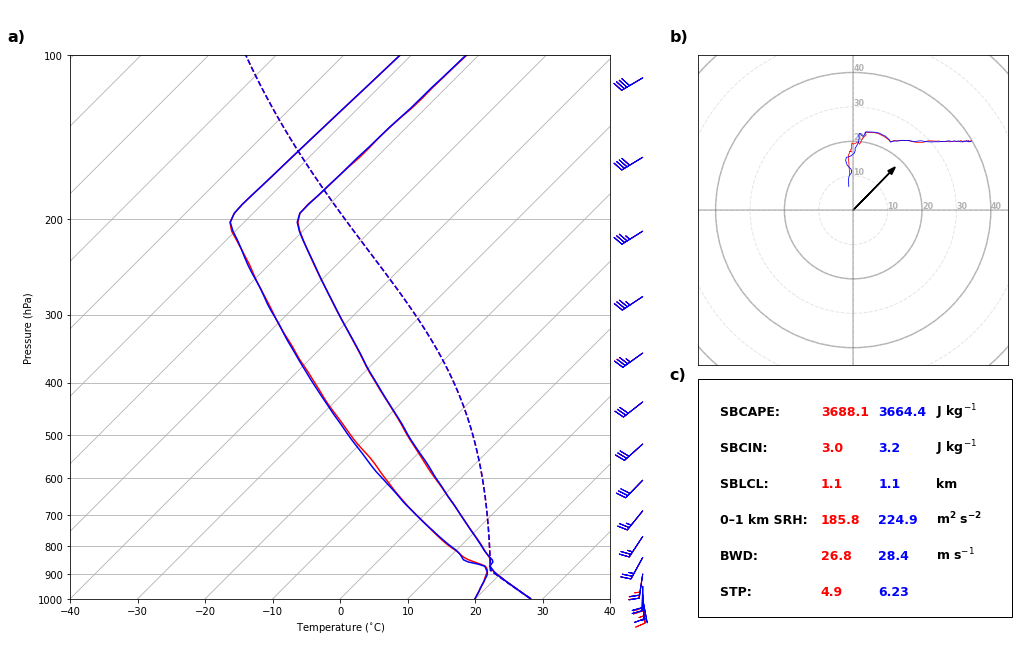

In [33]:
# This Cell Randomly Selects a point amongst the 112225, and plots the pseudo vs. instantaneous sounding


# Random Index
k = np.random.randint(0, P.shape[1])

# Initialize SkewT
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig, rotation=45)

# Initialize Hodograph   
ax = plt.axes((1.01, 0.45, 0.43, 0.43))
h = metpy.plots.Hodograph(ax, component_range=45.)

# Add alternating grid increments
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)


# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=8, weight='bold', alpha=0.3, zorder=0)
    
# Cosmetic Touches
skew.ax.set_xlabel('Temperature ($^{\circ}$C)')
skew.ax.set_ylabel('Pressure (hPa)')
        
#Relative Storm Motion 
offset_u = 12.2*units.meter_per_second
offset_v = 12.5*units.meter_per_second

# Plot Bunkers Storm Motion
h.ax.arrow(0, 0, offset_u.magnitude, offset_v.magnitude, linewidth=1.5, color='black', length_includes_head=True, head_width=1.5)

# ---------------------------------------------------------------------------------------------------------------

# Plot PseudoSounding
length = len(P[:,k][::8])
skew.plot(P[:,k]*units.Pa, T[:,k]*units.degK, color='r')
skew.plot(P[:,k]*units.Pa, Td[:,k]*units.degK, color = 'r')
skew.plot(P[:,k]*units.Pa, parc_T[:,k]*units.degK, color = 'r', linestyle = '--')
skew.plot_barbs(P[:,k][::8]*units.Pa, u[:,k][::8]*units.meter_per_second+offset_u, 
                v[:,k][::8]*units.meter_per_second+offset_v, color = 'r', xloc=1.06, y_clip_radius = 0.09)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# Plot Pseudo Hodograph
h.plot(u[:,k]*units.meter_per_second+offset_u, v[:,k]*units.meter_per_second+offset_v, color='r', linewidth = 0.8)

# Plot Instantaneous Sounding/Hodograph
length = len(inst_P[:,k][::8])
skew.plot(inst_P[:,k]*units.Pa, inst_T[:,k]*units.degK, color='b')
skew.plot(inst_P[:,k]*units.Pa, inst_Td[:,k]*units.degK, color = 'b')
skew.plot(inst_P[:,k]*units.Pa, inst_parc_T[:,k]*units.degK, color = 'b', linestyle = '--')
skew.plot_barbs(inst_P[:,k][::8]*units.Pa, inst_u[:,k][::8]*units.meter_per_second+offset_u, 
                inst_v[:,k][::8]*units.meter_per_second+offset_v, color = 'b', xloc=1.06, y_clip_radius = 0.09)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# Plot Instantaneous Hodograph
h.plot(inst_u[:,k]*units.meter_per_second+offset_u, inst_v[:,k]*units.meter_per_second+offset_v, color='b', linewidth = 0.8)

# ---------------------------------------------------------------------------------------------------------------------------------

# Compute Forecasting Parameters

# Pseudo Profile Parameters 
# CAPE/CIN (wrf)
Height = z_data*1000 #"Geopotential Height"
Terrain = 0 #Terrain (Assuming Flat Surface)
P_sfc = P[:,k][0]/100 # Surface Pressure
# WRF CAPE Computation
results = wrf.cape_3d(P[:,k]/100, T[:,k], qv[:,k], Height, Terrain, P_sfc, ter_follow = True, meta = True)
SBCAPE = results[0][0].values
SBCIN = results[1][0].values
SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                        u[:,k]*units.meter_per_second+offset_u, v[:,k]*units.meter_per_second+offset_v, bottom = 7.5*units('m'), 
                                        depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
# LCL
p_LCL = mpcalc.lcl(P[:,k][0]*units.Pa, T[:,k][0]*units.degK, Td[:,k][0]*units.degK)[0]
SBLCL = mpcalc.pressure_to_height_std(p_LCL)
# Height indices for ~ 0, 6 km and BWD
z_6km = (np.abs(z_data.values -6)).argmin()
z_0km = 0
u_sfc = u[:,k][z_0km]
v_sfc = v[:,k][z_0km]
u_6km = u[:,k][z_6km]
v_6km = v[:,k][z_6km]
BWD_u = u_6km - u_sfc
BWD_v = v_6km - v_sfc
BWD = ((BWD_u**2 + BWD_v**2)**(1/2))
# STP
STP = (SBCAPE/1500)*((2000-1000*SBLCL.magnitude)/1000)*(SRH1km.magnitude/150)*((200+SBCIN)/150)*(BWD/20)
        

# Instantaneous Profile Parameters
Height = z_data*1000 #"Geopotential Height"
Terrain = 0 #Terrain (Assuming Flat Surface)
inst_P_sfc = inst_P[:,k][0]/100 # Surface Pressure
# WRF CAPE Computation
results = wrf.cape_3d(inst_P[:,k]/100, inst_T[:,k], inst_qv[:,k], Height, Terrain, inst_P_sfc, ter_follow = True, meta = True)
inst_SBCAPE = results[0][0].values
inst_SBCIN = results[1][0].values
# Print Comparison
#print(f'Metpy: {CIN}, WRF: {SBCIN}')
inst_SRH1km = mpcalc.storm_relative_helicity(z_data.values*units('km'), 
                                        inst_u[:,k]*units.meter_per_second+offset_u, inst_v[:,k]*units.meter_per_second+offset_v, bottom = 7.5*units('m'), 
                                        depth = 1*units('km'), storm_u = offset_u, storm_v = offset_v)[0]
# LCL
inst_p_LCL = mpcalc.lcl(inst_P[:,k][0]*units.Pa, inst_T[:,k][0]*units.degK, inst_Td[:,k][0]*units.degK)[0]
inst_SBLCL = mpcalc.pressure_to_height_std(inst_p_LCL)
# Height indices for ~ 0, 6 km and BWD
z_6km = (np.abs(z_data.values -6)).argmin()
z_0km = 0
u_sfc = inst_u[:,k][z_0km]
v_sfc = inst_v[:,k][z_0km]
u_6km = inst_u[:,k][z_6km]
v_6km = inst_v[:,k][z_6km]
BWD_u = u_6km - u_sfc
BWD_v = v_6km - v_sfc
inst_BWD = ((BWD_u**2 + BWD_v**2)**(1/2))
# STP
inst_STP = (inst_SBCAPE/1500)*((2000-1000*inst_SBLCL.magnitude)/1000)*(inst_SRH1km.m/150)*((200+inst_SBCIN)/150)*(inst_BWD/20)

# --------------------------------------------------------------------------------------------------------------------------

# List Forecasting Parameters in Text Box 

fig.patches.extend([plt.Rectangle((1.01, 0.1), 0.435, 0.33,
                                  edgecolor='black', facecolor='white',
                                  linewidth=1, alpha=1, transform=fig.transFigure,
                                  figure=fig)])
# Add each parameter title to the bottom right text box
plt.figtext(1.04, 0.38, 'SBCAPE: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.33, 'SBCIN: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.28, 'SBLCL: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.23, '0–1 km SRH: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.18, 'BWD: ', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.04, 0.13, 'STP: ', weight='bold', fontsize=12.5,
            color='k')

# Plot PseudoValues
plt.figtext(1.18, 0.38, f'{round(float(SBCAPE), 1)}', weight='bold', fontsize=12.5,
            color='red')
plt.figtext(1.18, 0.33, f'{round(float(SBCIN), 1)}', weight='bold', fontsize=12.5,
            color='red')
plt.figtext(1.18, 0.28, f'{round(float(SBLCL.m), 1)}', weight='bold', fontsize=12.5,
            color='red')
plt.figtext(1.18, 0.23, f'{round(SRH1km.m,1)}', fontsize=12.5, weight='bold',
            color='red')
plt.figtext(1.18, 0.18, f'{round(float(BWD), 1)}', weight='bold', fontsize=12.5,
            color='red')
plt.figtext(1.18, 0.13, f'{round(STP,2)}', weight='bold', fontsize=12.5,
            color='red')


# Plot Instantaneous Values 
plt.figtext(1.26, 0.38, f'{round(float(inst_SBCAPE), 1)}', weight='bold', fontsize=12.5,
            color='blue')
plt.figtext(1.26, 0.33, f'{round(float(inst_SBCIN), 1)}', weight='bold', fontsize=12.5,
            color='blue')
plt.figtext(1.26, 0.28, f'{round(float(inst_SBLCL.m), 1)}', weight='bold', fontsize=12.5,
            color='blue')
plt.figtext(1.26, 0.23, f'{round(inst_SRH1km.m,1)}', fontsize=12.5, weight='bold',
            color='blue')
plt.figtext(1.26, 0.18, f'{round(float(inst_BWD), 1)}', weight='bold', fontsize=12.5,
            color='blue')
plt.figtext(1.26, 0.13, f'{round(inst_STP,2)}', weight='bold', fontsize=12.5,
            color='blue')

# Add Units to each parameters
plt.figtext(1.34, 0.38, 'J kg$^{-1}$', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.34, 0.33, 'J kg$^{-1}$', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.34, 0.28, 'km', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.34, 0.23, '$\mathbf{{ m^2 \ s^{{-2}}}}$', weight='bold', fontsize=12.5,
            color='k')
plt.figtext(1.34, 0.18, 'm s$^{-1}$', weight='bold', fontsize=12.5,
            color='k')

# Save and Print Randomly Selected Point
print(k)

# Add subplot labels to skewT and hodograph 
plt.figtext(0.05, 0.9, 'a)', fontsize = 16, weight = 'bold')
plt.figtext(0.97, 0.9, 'b)', fontsize = 16, weight = 'bold')
plt.figtext(0.97, 0.43, 'c)', fontsize = 16, weight = 'bold')
# Show the plot
plt.show()

      


